In [ ]:
import wandb
from tqdm import tqdm
import numpy as np

api = wandb.Api()

def load_lcbench_varying_cost_runs(data, acq):
    runs = api.runs(path="ziv-scully-group/PandoraBayesOpt", filters={
        "sweep": "4fxoyssk",
        "config.dataset_name": data,
        "config.acquisition_function": acq},
        )
    
    configs_and_metrics = []
    for run in tqdm(runs):
        metric_keys = ["config id", "cumulative cost", "current best id", "current best observed", "StablePBGI(1e-5) acq", "StablePBGI(1e-6) acq", "StablePBGI(1e-7) acq", "LogEIC acq", "exp min regret gap"]
        history = list(run.scan_history(keys = metric_keys, page_size=1_000_000_000))
        metrics = {k: [d[k] for d in history] for k in metric_keys}
        configs_and_metrics.append((run.config, metrics))

    return configs_and_metrics

In [ ]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
acquisition_functions = {
        "StablePBGI(1e-5)": "PBGI(1e-5)",
        "StablePBGI(1e-6)": "PBGI(1e-6)", 
        "PBGI(1e-7)": "PBGI(1e-7)", 
        "LogEIC": "LogEIC"
    }

In [3]:
grouped_runs = {(d, a): load_lcbench_varying_cost_runs(d, a) for d in dataset_names for a in acquisition_functions}

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [ ]:
from collections import defaultdict

config_id_per_acq = defaultdict(dict)
cumulative_cost_per_acq = defaultdict(dict)
current_best_id_per_acq = defaultdict(dict)
current_best_observed_per_acq = defaultdict(dict)
acq_per_acq = defaultdict(dict)
PBGI_1e_5_acq_per_acq = defaultdict(dict)
PBGI_1e_6_acq_per_acq = defaultdict(dict)
PBGI_1e_7_acq_per_acq = defaultdict(dict)
LogEIC_acq_per_acq = defaultdict(dict)
exp_min_regret_gap_per_acq = defaultdict(dict)

for d in dataset_names:
    for a in acquisition_functions.keys():
        config_and_metrics_per_seed = grouped_runs[(d,a)]

        # Extract metrics along with the seeds for sorting
        seeds_and_metrics = [
            (config['seed'], m['cumulative cost'], m['config id'], m['current best id'], m['current best observed'], m['PBGI(1e-5) acq'], m['StablePBGI(1e-6) acq'], m['StablePBGI(1e-7) acq'], m['LogEIC acq'], m['exp min regret gap'])
            for config, m in config_and_metrics_per_seed
            if len(m['current best observed']) > 0
        ]

        # Sort by seed
        seeds_and_metrics.sort(key=lambda x: x[0])

        # Extract sorted metrics
        cumulative_cost_per_seed = np.array([item[1] for item in seeds_and_metrics])
        config_id_per_seed = np.array([item[2] for item in seeds_and_metrics])
        current_best_id_per_seed = np.array([item[3] for item in seeds_and_metrics])
        current_best_observed_per_seed = np.array([item[4] for item in seeds_and_metrics])
        PBGI_1e_5_acq_per_seed = np.array([item[5] for item in seeds_and_metrics], dtype=float)
        PBGI_1e_6_acq_per_seed = np.array([item[6] for item in seeds_and_metrics], dtype=float)
        PBGI_1e_7_acq_per_seed = np.array([item[7] for item in seeds_and_metrics], dtype=float)
        LogEIC_acq_per_seed = np.array([item[8] for item in seeds_and_metrics], dtype=float)
        exp_min_regret_gap_per_seed = np.array([item[9] for item in seeds_and_metrics], dtype=float)

        print(d, a, config_id_per_seed.shape)

        cumulative_cost_per_acq[d][acquisition_functions[a]] = cumulative_cost_per_seed
        config_id_per_acq[d][acquisition_functions[a]] = config_id_per_seed
        current_best_id_per_acq[d][acquisition_functions[a]] = current_best_id_per_seed
        current_best_observed_per_acq[d][acquisition_functions[a]] = current_best_observed_per_seed
        PBGI_1e_5_acq_per_acq[d][acquisition_functions[a]] = PBGI_1e_5_acq_per_seed
        PBGI_1e_6_acq_per_acq[d][acquisition_functions[a]] = PBGI_1e_6_acq_per_seed
        PBGI_1e_7_acq_per_acq[d][acquisition_functions[a]] = PBGI_1e_7_acq_per_seed
        LogEIC_acq_per_acq[d][acquisition_functions[a]] = LogEIC_acq_per_seed
        exp_min_regret_gap_per_acq[d][acquisition_functions[a]] = exp_min_regret_gap_per_seed

Fashion-MNIST StablePBGI(1e-5) (50, 201)
Fashion-MNIST StablePBGI(1e-6) (50, 201)
Fashion-MNIST StablePBGI(1e-7) (50, 201)
Fashion-MNIST LogEIC (50, 201)
adult StablePBGI(1e-5) (50, 201)
adult StablePBGI(1e-6) (50, 201)
adult StablePBGI(1e-7) (50, 201)
adult LogEIC (50, 201)
higgs StablePBGI(1e-5) (50, 201)
higgs StablePBGI(1e-6) (50, 201)
higgs StablePBGI(1e-7) (50, 201)
higgs LogEIC (50, 201)
volkert StablePBGI(1e-5) (50, 201)
volkert StablePBGI(1e-6) (50, 201)
volkert StablePBGI(1e-7) (50, 201)
volkert LogEIC (50, 201)


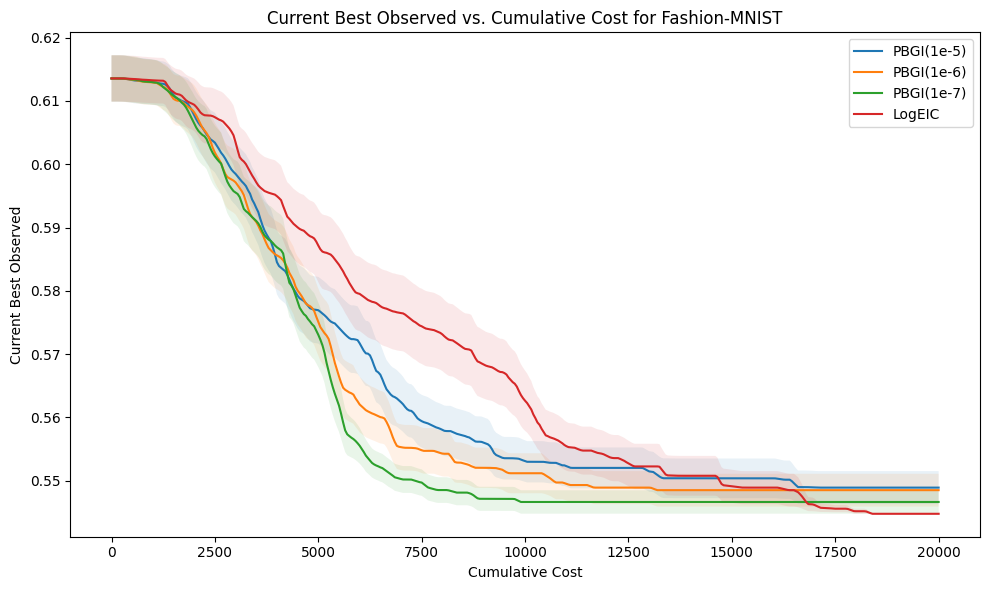

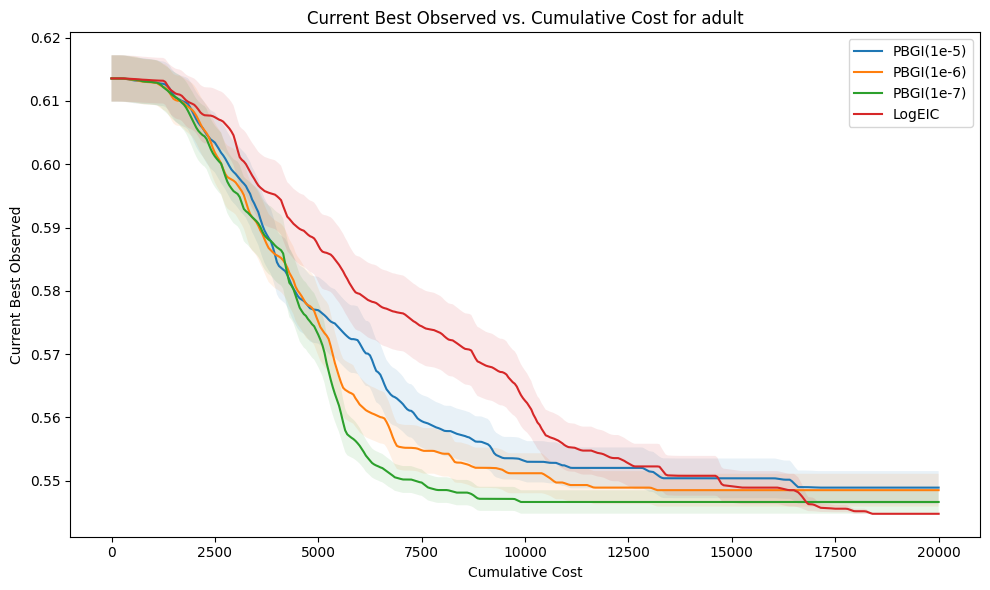

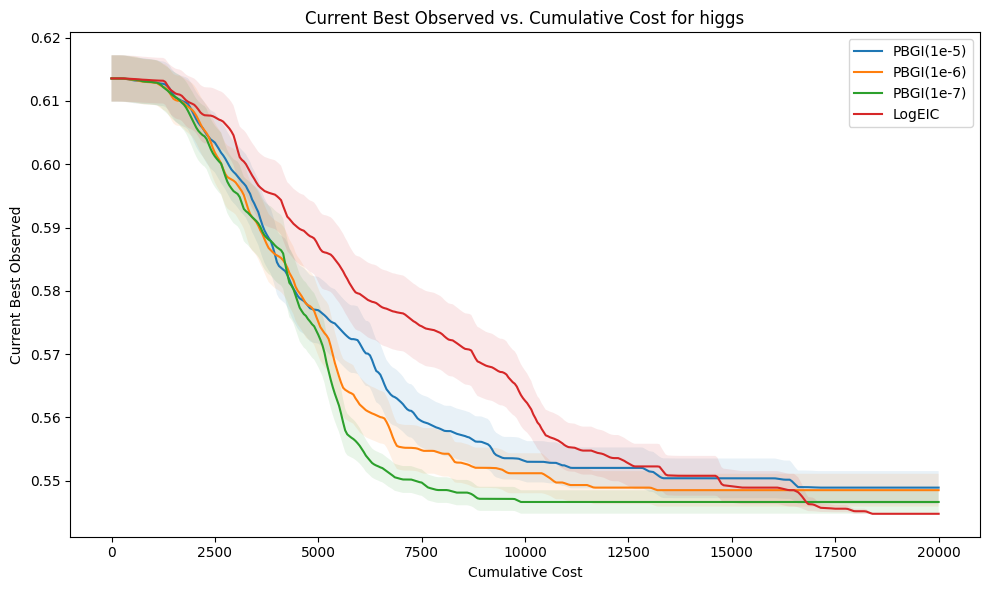

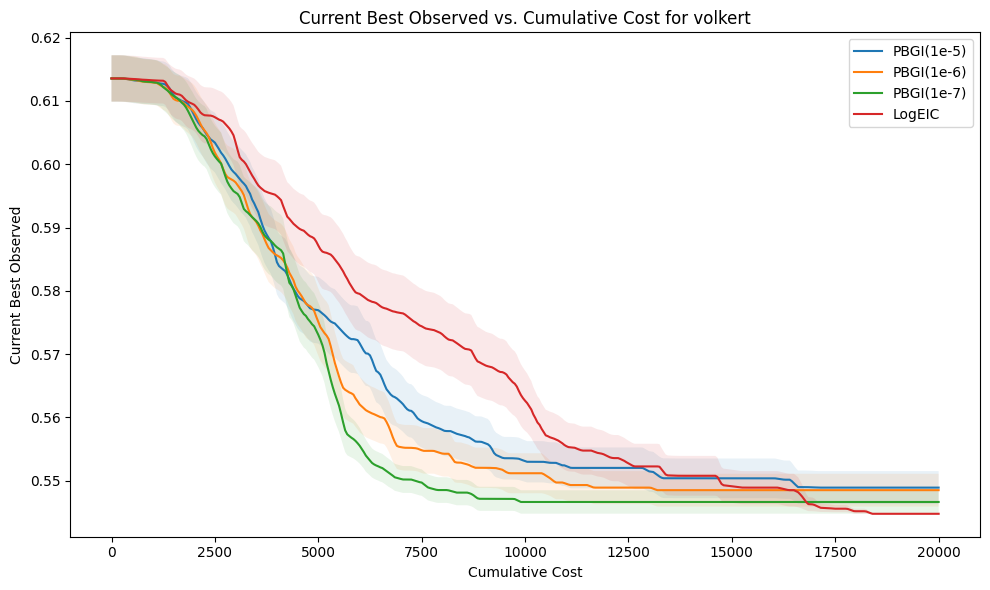

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
# Adjust the number of grid points as needed (here, we use 401 points).
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed
        interpolated_curves = []
        
        # Loop over each seed (assume the first dimension indexes seeds)
        for seed_id in range(len(cumulative_cost_per_acq[d][a])):
            # Get the seed's cumulative cost and current best observed arrays.
            cum_cost = np.array(cumulative_cost_per_acq[d][a][seed_id])
            best_obs = np.array(current_best_observed_per_acq[d][a][seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            best_obs_sorted = best_obs[sort_id]
            
            # Use interpolation to compute the best observed at the common cost_grid.
            # np.interp assumes the x-values (cum_cost_sorted) are increasing.
            interp_best_obs = np.interp(cost_grid, cum_cost_sorted, best_obs_sorted)
            interpolated_curves.append(interp_best_obs)
        
        # Convert to a NumPy array with shape (n_seeds, len(cost_grid))
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute the mean and standard error across seeds at each grid point.
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot the mean curve and the shaded area for standard error.
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize the plot.
    plt.title(f"Current Best Observed vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Current Best Observed")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
%%capture
from pprint import pprint
from LCBench.api import Benchmark
import os

os.makedirs("../LCBench/cached", exist_ok=True)
bench_dir = "../LCBench/cached/six_datasets_lw.json"
bench = Benchmark(bench_dir, cache=False)

In [47]:
from collections import defaultdict
import numpy as np

# Initialize dictionaries to hold the per-iteration test metrics for each dataset and acquisition function.
test_cross_entropy_per_acq = defaultdict(dict)
test_accuracy_per_acq = defaultdict(dict)

# Loop over each dataset and acquisition function.
for d in dataset_names:
    for a in acquisition_functions.values():
        # current_best_id_per_acq[d][a] is assumed to be a 2D array with shape (n_seeds, n_iterations)
        best_ids = current_best_id_per_acq[d][a]
        n_seeds, n_iterations = best_ids.shape
        
        # Prepare arrays to store the test metrics for each seed and each iteration.
        test_ce_mat = np.empty((n_seeds, n_iterations))
        test_acc_mat = np.empty((n_seeds, n_iterations))
        
        # Use the precomputed best configuration IDs to query test metrics.
        for s in range(n_seeds):
            for i in range(n_iterations):
                config_id = best_ids[s, i]
                test_ce_mat[s, i] = bench.query(d, "final_test_cross_entropy", config_id)
                test_acc_mat[s, i] = bench.query(d, "final_test_accuracy", config_id)
        
        # Store the resulting matrices in the dictionaries.
        test_cross_entropy_per_acq[d][a] = test_ce_mat
        test_accuracy_per_acq[d][a] = test_acc_mat

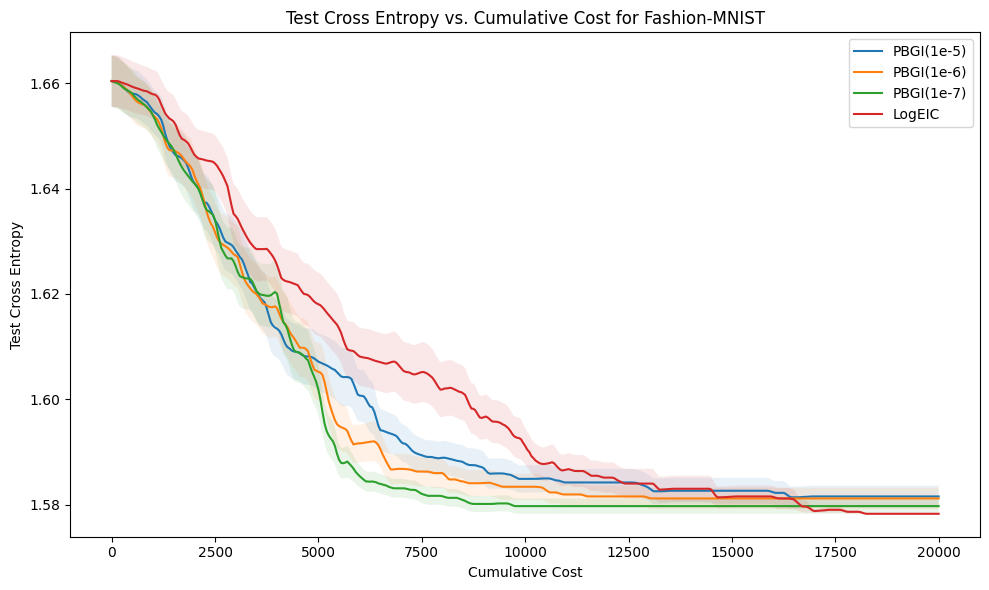

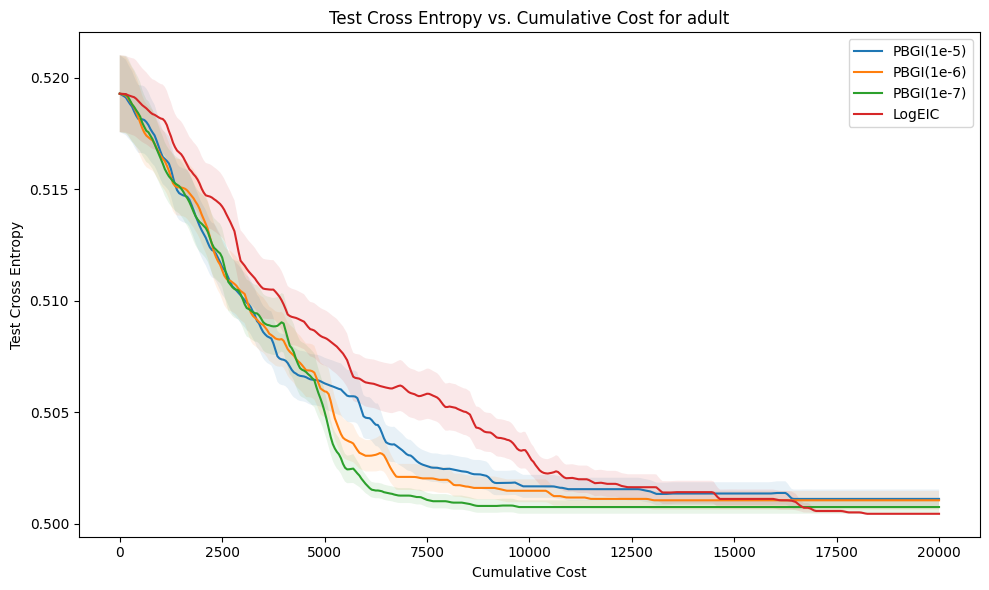

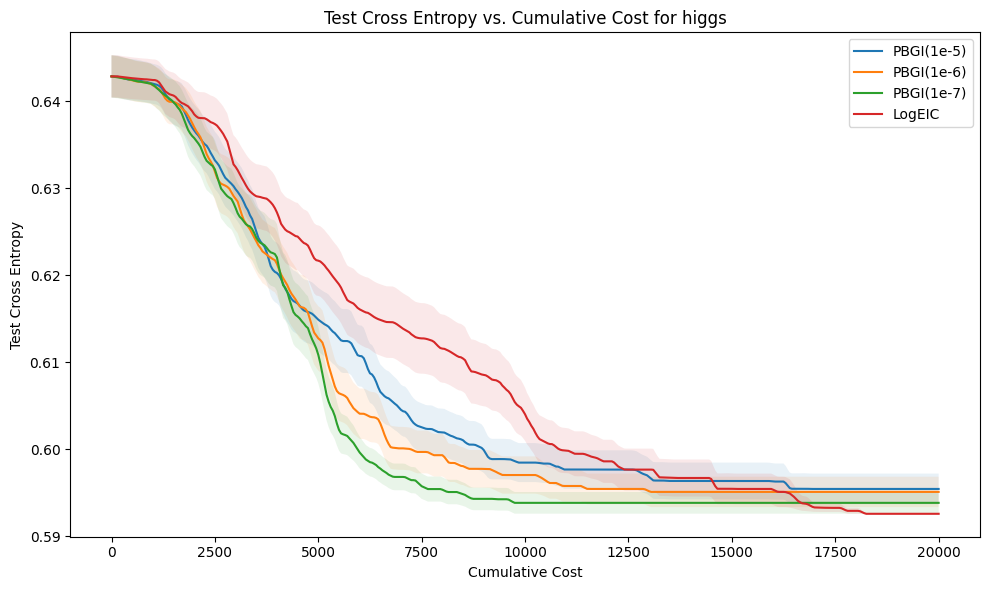

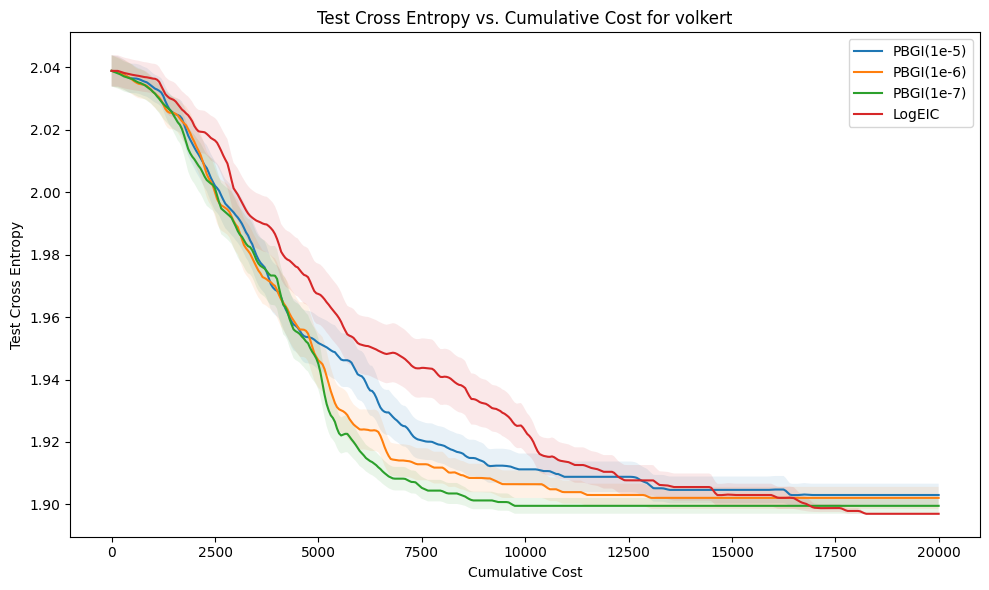

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed.
        interpolated_curves = []
        
        # Loop over each seed (assuming the first dimension indexes seeds).
        for seed_id in range(len(cumulative_cost_per_acq[d][a])):
            # Get the seed's cumulative cost and test cross entropy arrays.
            cum_cost = np.array(cumulative_cost_per_acq[d][a][seed_id])
            test_ce = np.array(test_cross_entropy_per_acq[d][a][seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            test_ce_sorted = test_ce[sort_id]
            
            # Use interpolation to compute test cross entropy at the common cost_grid.
            interp_test_ce = np.interp(cost_grid, cum_cost_sorted, test_ce_sorted)
            interpolated_curves.append(interp_test_ce)
        
        # Convert the list to a NumPy array (shape: [n_seeds, len(cost_grid)]).
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute the mean and standard error (std/sqrt(n_seeds)) across seeds.
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot the mean curve with a shaded standard error region.
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize the plot.
    plt.title(f"Test Cross Entropy vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Test Cross Entropy")
    plt.legend()
    plt.tight_layout()
    plt.show()

[Fashion-MNIST] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[Fashion-MNIST] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[Fashion-MNIST] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[Fashion-MNIST] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


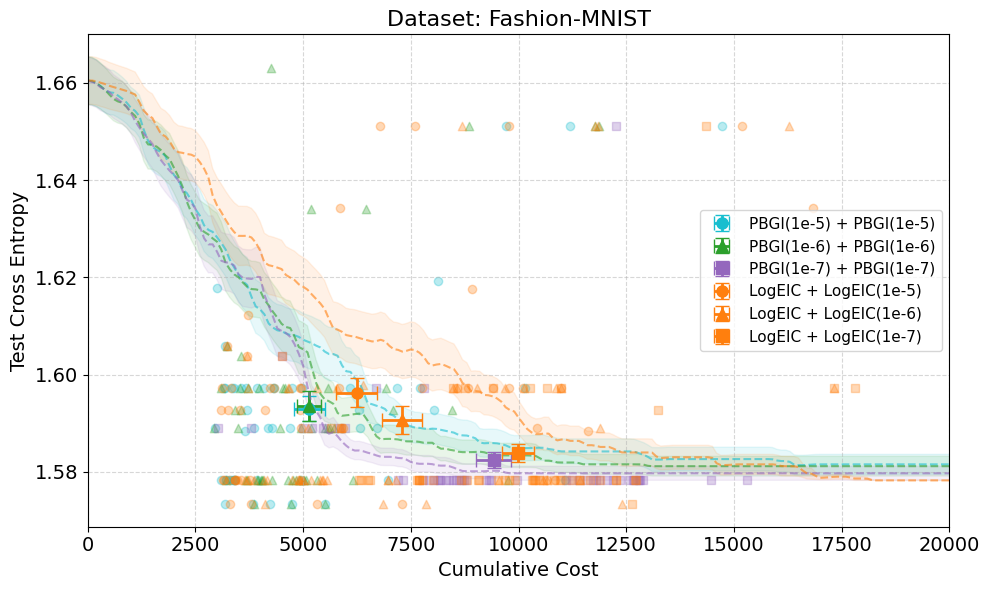

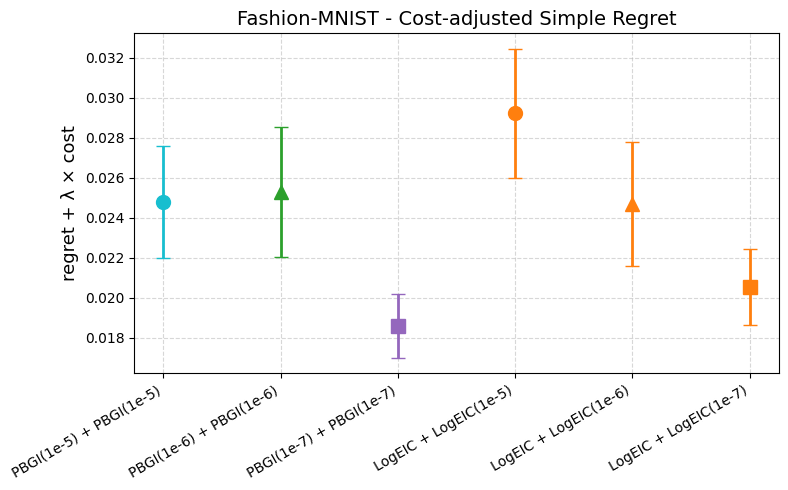

[adult] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[adult] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[adult] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[adult] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[adult] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[adult] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


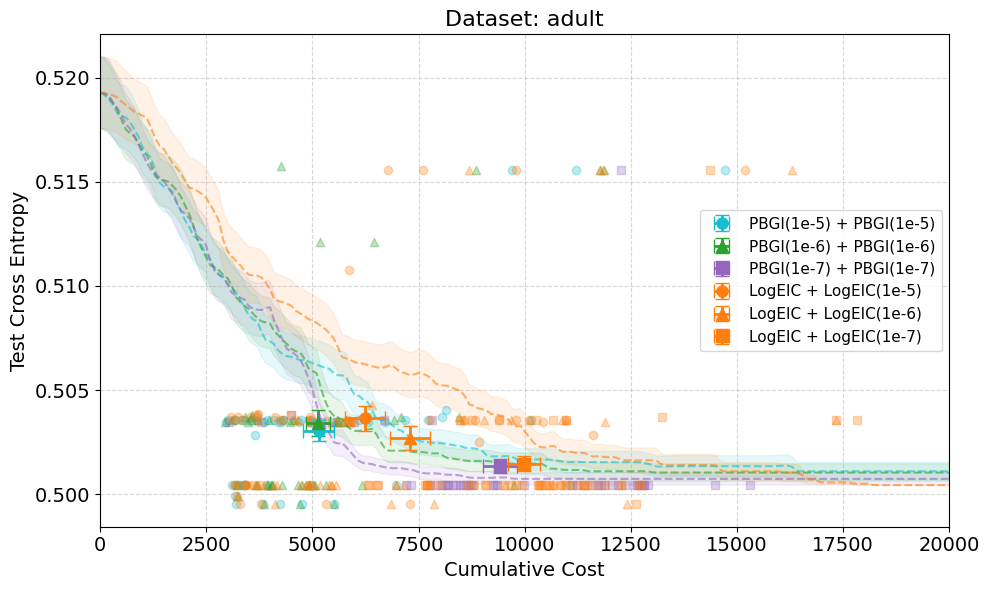

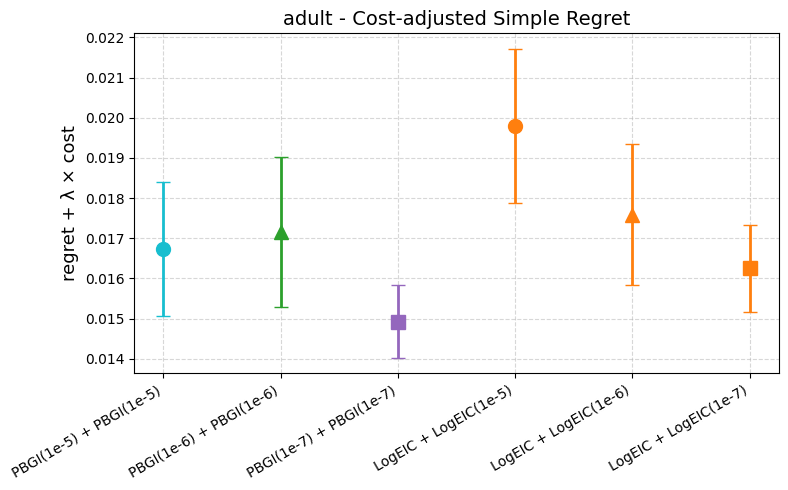

[higgs] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[higgs] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[higgs] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[higgs] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


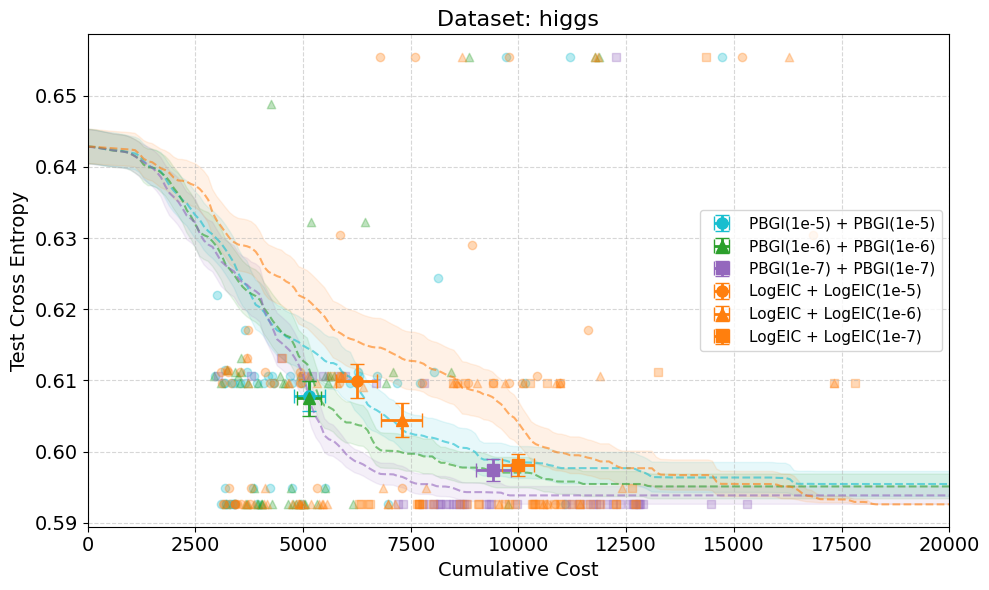

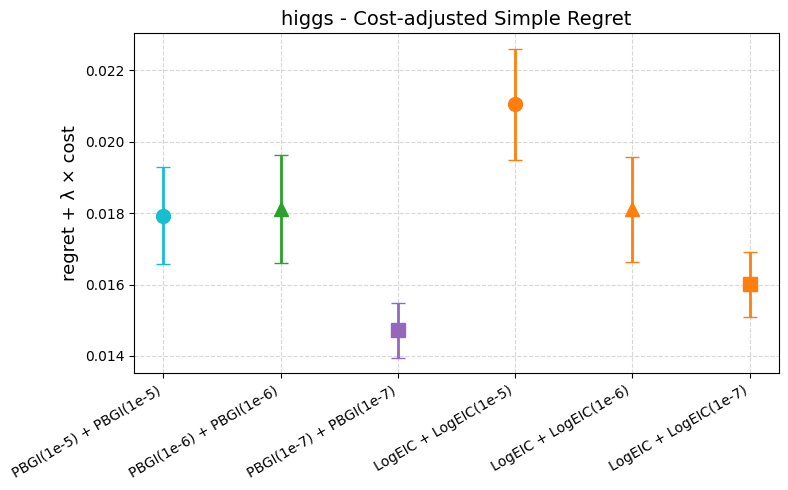

[volkert] PBGI(1e-5) + PBGI(1e-5) — No-stop count: 0 / 50
[volkert] PBGI(1e-6) + PBGI(1e-6) — No-stop count: 0 / 50
[volkert] PBGI(1e-7) + PBGI(1e-7) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-5) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-6) — No-stop count: 0 / 50
[volkert] LogEIC + LogEIC(1e-7) — No-stop count: 0 / 50


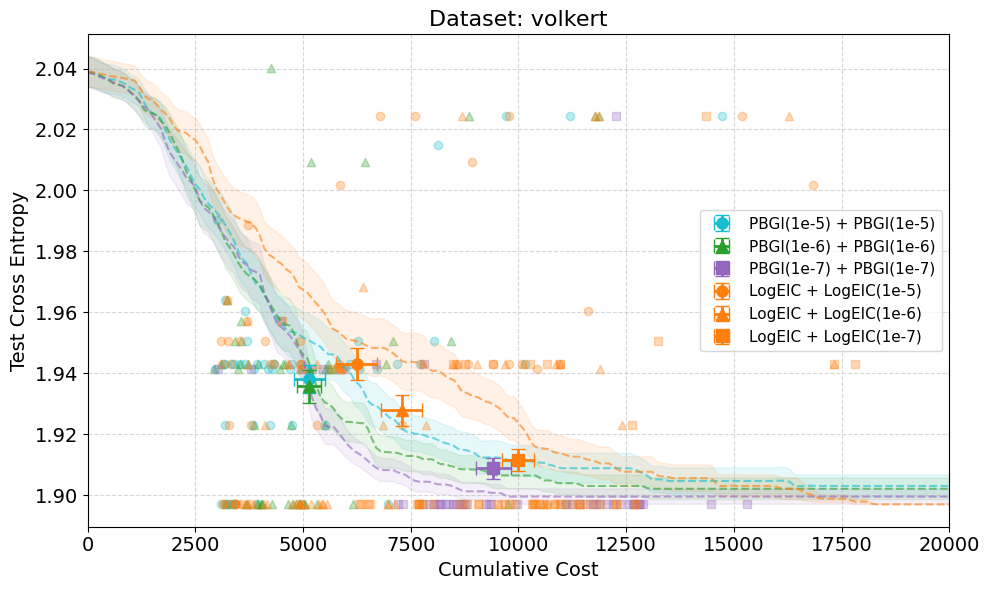

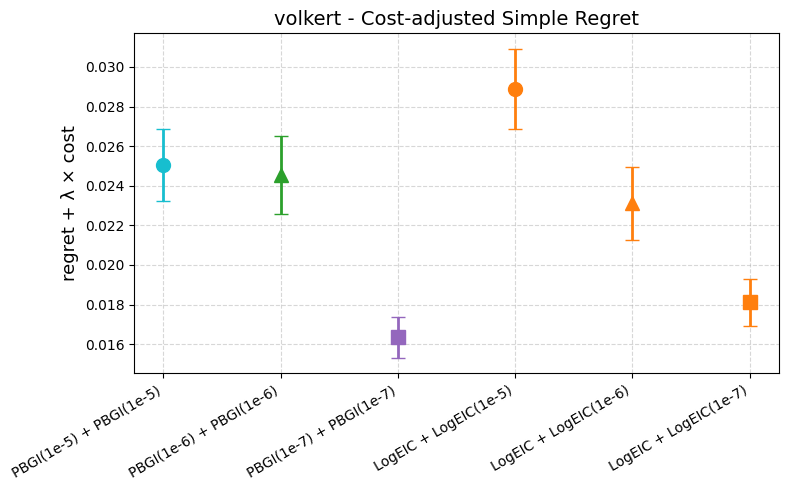

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Define tab colors for each stopping rule type:
color_dict = {
    'PBGI(1e-5)': 'tab:cyan',
    'PBGI(1e-6)': 'tab:green',
    'PBGI(1e-7)': 'tab:purple',
    'LogEIC': 'tab:orange',
}

# Marker styles by parameter:
marker_dict = {
    '1e-5': 'o',     # circle
    '1e-6': '^',     # triangle
    '1e-7': 's',     # square
}

# Stopping rules:
stopping_rules = [
    {'label': 'PBGI(1e-5) + PBGI(1e-5)', 'acq_key': 'PBGI(1e-5)', 'color': color_dict['PBGI(1e-5)'], 'marker': marker_dict['1e-5'],
     'condition_fn': lambda i, seed_id, d: (
         PBGI_1e_5_acq_per_acq[d]['PBGI(1e-5)'][seed_id][i] >= 
         current_best_observed_per_acq[d]['PBGI(1e-5)'][seed_id][i-1])},
    {'label': 'PBGI(1e-6) + PBGI(1e-6)', 'acq_key': 'PBGI(1e-6)', 'color': color_dict['PBGI(1e-6)'], 'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         PBGI_1e_6_acq_per_acq[d]['LogEIC'][seed_id][i] >= 
         current_best_observed_per_acq[d]['PBGI(1e-6)'][seed_id][i-1])},
    {'label': 'PBGI(1e-7) + PBGI(1e-7)', 'acq_key': 'PBGI(1e-7)', 'color': color_dict['PBGI(1e-7)'], 'marker': marker_dict['1e-7'],
     'condition_fn': lambda i, seed_id, d: (
         PBGI_1e_7_acq_per_acq[d]['PBGI(1e-7)'][seed_id][i] >= 
         current_best_observed_per_acq[d]['PBGI(1e-7)'][seed_id][i-1])},
    {'label': 'LogEIC + LogEIC(1e-5)', 'acq_key': 'LogEIC', 'color': color_dict['LogEIC'], 'marker': marker_dict['1e-5'],
     'condition_fn': lambda i, seed_id, d: (
         LogEIC_acq_per_acq[d]['LogEIC'][seed_id][i] <= np.log(1e-5))},
    {'label': 'LogEIC + LogEIC(1e-6)', 'acq_key': 'LogEIC', 'color': color_dict['LogEIC'], 'marker': marker_dict['1e-6'],
     'condition_fn': lambda i, seed_id, d: (
         LogEIC_acq_per_acq[d]['LogEIC'][seed_id][i] <= np.log(1e-6))},
    {'label': 'LogEIC + LogEIC(1e-7)', 'acq_key': 'LogEIC', 'color': color_dict['LogEIC'], 'marker': marker_dict['1e-7'],
     'condition_fn': lambda i, seed_id, d: (
         LogEIC_acq_per_acq[d]['LogEIC'][seed_id][i] <= np.log(1e-7))},
]

cost_grid = np.linspace(0, 80000, 801)
lmbda = 1e-6  # you can adjust λ if needed

# === NEW: Initialize cost-adjusted simple regret collector ===
cost_adjusted_simple_regret = {rule['label']: [] for rule in stopping_rules}

# Loop through datasets
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    plotted_curves = set()

    x_limit = 20000
    best_test_ce = bench.query_best_final(d, "final_test_cross_entropy", "final_test_cross_entropy", 1999)

    for rule in stopping_rules:
        acq_key = rule['acq_key']
        color = rule['color']
        label = rule['label']
        marker = rule['marker']

        if acq_key not in plotted_curves:
            interpolated_curves = []
            for seed_id in range(len(test_cross_entropy_per_acq[d][acq_key])):
                cost_arr = np.array(cumulative_cost_per_acq[d][acq_key][seed_id])
                ce_arr = np.array(test_cross_entropy_per_acq[d][acq_key][seed_id])
                sort_idx = np.argsort(cost_arr)
                cost_sorted = cost_arr[sort_idx]
                ce_sorted = ce_arr[sort_idx]
                interp_ce = np.interp(cost_grid, cost_sorted, ce_sorted)
                interpolated_curves.append(interp_ce)
            interpolated_curves = np.array(interpolated_curves)
            mean_ce = np.mean(interpolated_curves, axis=0)
            sem_ce = np.std(interpolated_curves, axis=0) / np.sqrt(len(interpolated_curves))
            plt.plot(cost_grid, mean_ce, linestyle='--', color=color, alpha=0.6)
            plt.fill_between(cost_grid, mean_ce - sem_ce, mean_ce + sem_ce, color=color, alpha=0.1)
            plotted_curves.add(acq_key)

        # Stopping logic
        stop_costs, stop_test_ce = [], []
        no_stop_count = 0
        n_seeds = len(test_cross_entropy_per_acq[d][acq_key])
        for seed_id in range(n_seeds):
            test_ce_arr = test_cross_entropy_per_acq[d][acq_key][seed_id]
            cost_arr = cumulative_cost_per_acq[d][acq_key][seed_id]
            if len(test_ce_arr) < 20:
                stop_id = len(test_ce_arr) - 1
            else:
                stop_id = next(
                    (i for i in range(20, len(test_ce_arr)) if rule['condition_fn'](i, seed_id, d)),
                    len(test_ce_arr) - 1
                )
            if stop_id == len(test_ce_arr) - 1:
                no_stop_count += 1
            stop_costs.append(cost_arr[stop_id])
            stop_test_ce.append(test_ce_arr[stop_id])

            # === NEW: Collect cost-adjusted simple regret ===
            regret = test_ce_arr[stop_id] - best_test_ce + lmbda * cost_arr[stop_id]
            cost_adjusted_simple_regret[label].append(regret)

        print(f"[{d}] {label} — No-stop count: {no_stop_count} / {n_seeds}")

        if stop_costs:
            stop_costs = np.array(stop_costs)
            stop_test_ce = np.array(stop_test_ce)
            plt.scatter(stop_costs, stop_test_ce, color=color, alpha=0.3, marker=marker)

            mx, my = np.mean(stop_costs), np.mean(stop_test_ce)
            sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
            sy = np.std(stop_test_ce) / np.sqrt(len(stop_test_ce))
            plt.errorbar(mx, my, xerr=sx, yerr=sy, fmt=marker, color=color,
                         markersize=8, capsize=5, linewidth=2, label=label)

    plt.xlabel("Cumulative Cost", fontsize=14)
    plt.ylabel("Test Cross Entropy", fontsize=14)
    plt.xlim(0, x_limit)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Dataset: {d}", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

    # === Plot cost-adjusted simple regret summary ===
    plt.figure(figsize=(8, 5))
    for rule in stopping_rules:
        label = rule['label']
        values = cost_adjusted_simple_regret[label]
        if values:
            values = np.array(values)
            mean_val = np.mean(values)
            err = np.std(values) / np.sqrt(len(values))
            plt.errorbar([label], [mean_val], yerr=[err], fmt=rule['marker'], color=rule['color'], capsize=5, markersize=10, linewidth=2)

    plt.xticks(rotation=30, ha='right')
    plt.ylabel("regret + λ × cost", fontsize=13)
    plt.title(f"{d} - Cost-adjusted Simple Regret", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

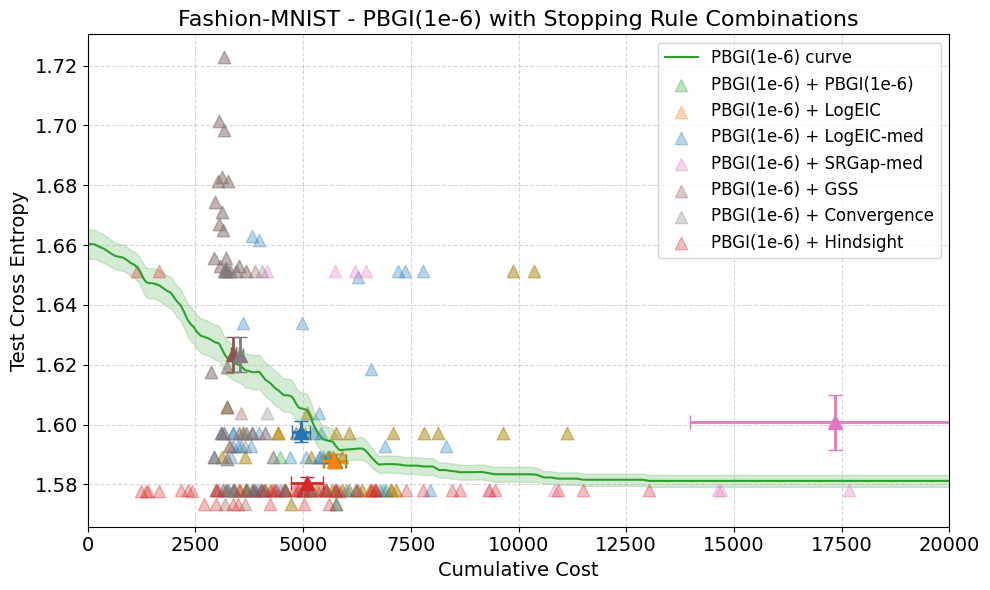

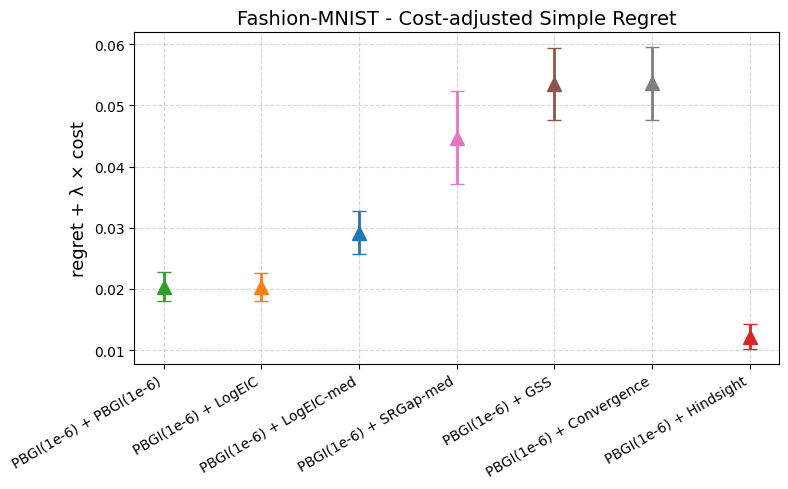

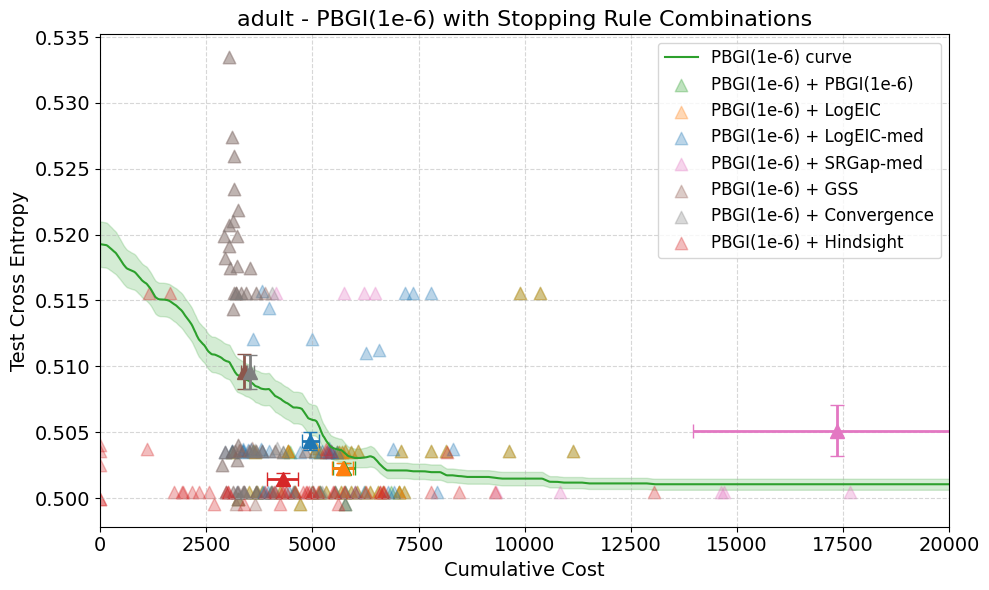

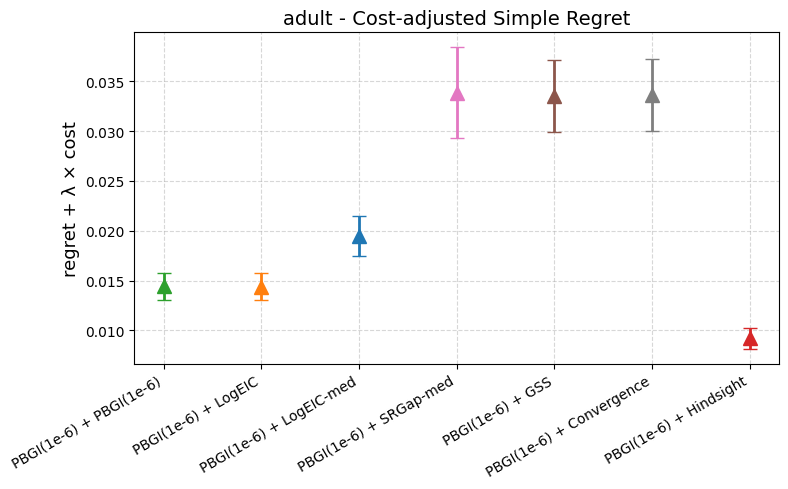

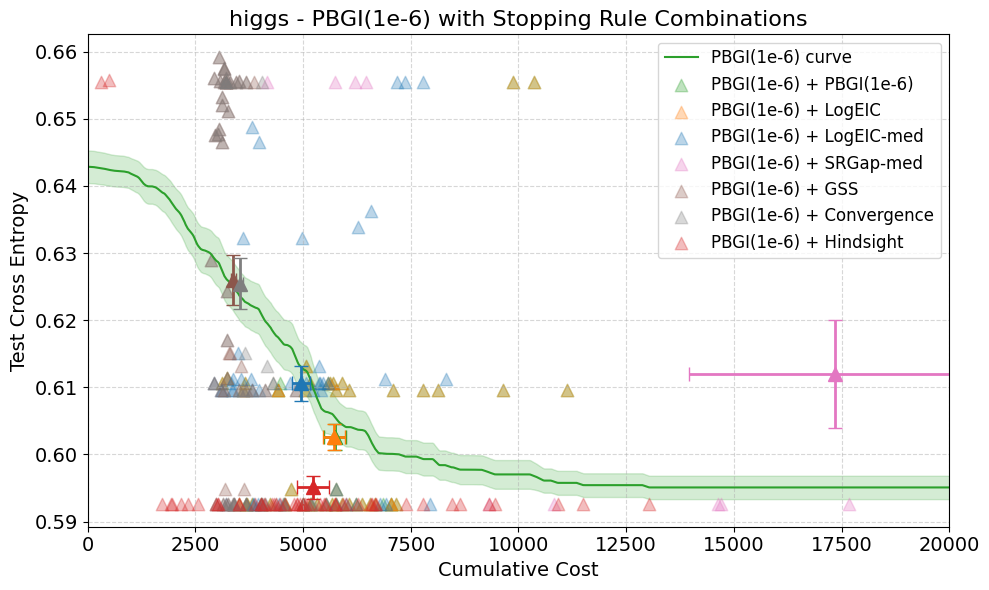

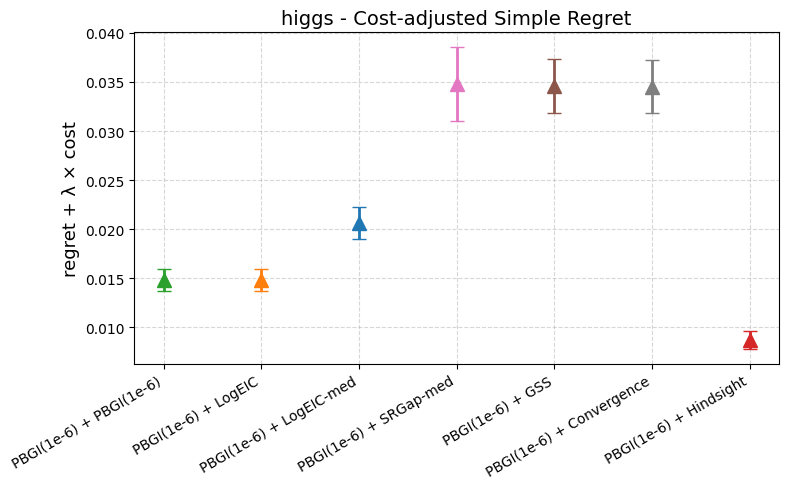

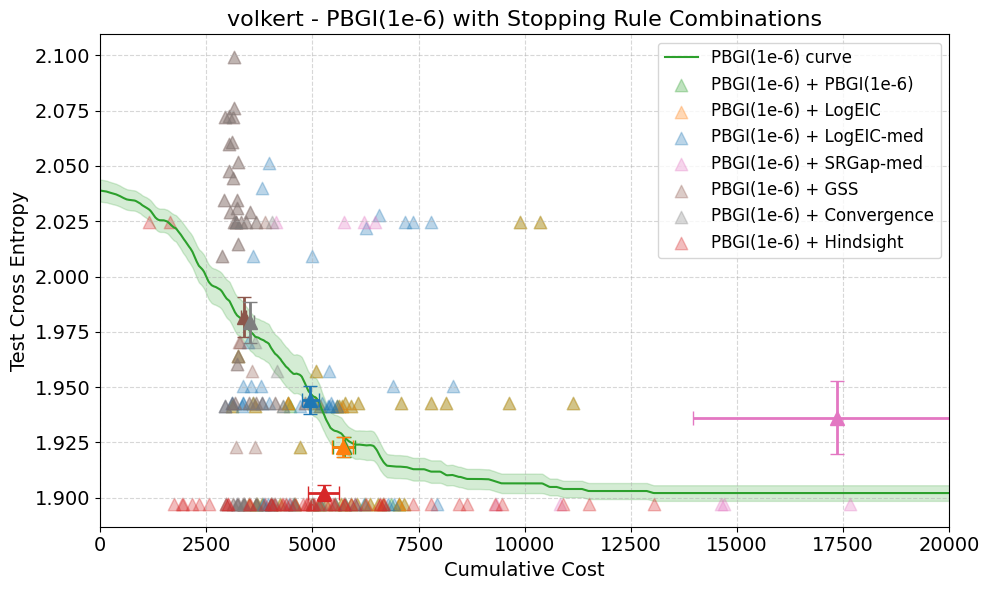

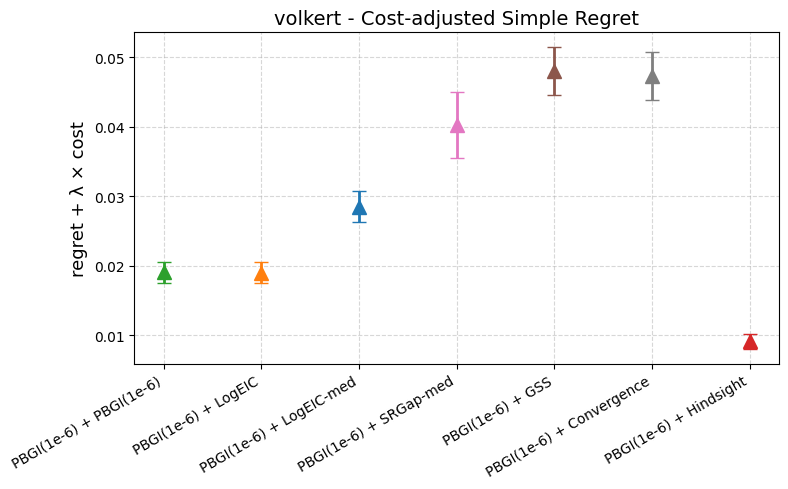

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors per stopping rule type (stp_key)
color_dict = {
    'PBGI(1e-6)': 'tab:green',
    'LogEIC': 'tab:orange',
    'LogEIC-med': 'tab:blue',
    'SRGap-med': 'tab:pink',
    'GSS': 'tab:brown',
    'Convergence': 'tab:gray',
    'Hindsight': 'tab:red'
}

# Marker styles
marker_dict = {
    '1e-6': '^',  # triangle
}

init = 20
fixed_acq = "PBGI(1e-6)"
lmbda = 1e-6

# Define stopping rules (with acq_key and stp_key separated)
stopping_rules = [
    {
        'acq_key': fixed_acq,
        'stp_key': fixed_acq,
        'marker': marker_dict['1e-6'],
        'color': color_dict[fixed_acq],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and PBGI_1e_6_acq_per_acq[d][fixed_acq][seed_id][i] >= 
            current_best_observed_per_acq[d][fixed_acq][seed_id][i-1]
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'LogEIC',
        'marker': marker_dict['1e-6'],
        'color': color_dict['LogEIC'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and LogEIC_acq_per_acq[d][fixed_acq][seed_id][i] <= np.log(1e-6)
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'LogEIC-med',
        'marker': marker_dict['1e-6'],
        'color': color_dict['LogEIC-med'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and
            LogEIC_acq_per_acq[d][fixed_acq][seed_id][i] <=
            np.log(0.01) + np.nanmedian(LogEIC_acq_per_acq[d][fixed_acq][seed_id][1:21])
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'SRGap-med',
        'marker': marker_dict['1e-6'],
        'color': color_dict['SRGap-med'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and
            exp_min_regret_gap_per_acq[d][fixed_acq][seed_id][i] <=
            0.1 * np.nanmedian(exp_min_regret_gap_per_acq[d][fixed_acq][seed_id][1:21])
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'GSS',
        'marker': marker_dict['1e-6'],
        'color': color_dict['GSS'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= 20 and
            ((
                np.nanpercentile(current_best_observed_per_acq[d][fixed_acq][seed_id][:i+1], 75) -
                np.nanpercentile(current_best_observed_per_acq[d][fixed_acq][seed_id][:i+1], 25)
            ) == 0 or
            (
                (
                    current_best_observed_per_acq[d][fixed_acq][seed_id][i-5] -
                    current_best_observed_per_acq[d][fixed_acq][seed_id][i]
                )
                /
                (
                    np.nanpercentile(current_best_observed_per_acq[d][fixed_acq][seed_id][:i+1], 75) -
                    np.nanpercentile(current_best_observed_per_acq[d][fixed_acq][seed_id][:i+1], 25)
                )
            ) <= 0.01)
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'Convergence',
        'marker': marker_dict['1e-6'],
        'color': color_dict['Convergence'],
        'is_hindsight': False,
        'condition_fn': lambda i, seed_id, d: (
            i >= init and
            current_best_observed_per_acq[d][fixed_acq][seed_id][i] ==
            current_best_observed_per_acq[d][fixed_acq][seed_id][i-5]
        )
    },
    {
        'acq_key': fixed_acq,
        'stp_key': 'Hindsight',
        'marker': marker_dict['1e-6'],
        'color': color_dict['Hindsight'],
        'is_hindsight': True
    }
]

# Create label dynamically:
for rule in stopping_rules:
    rule['label'] = f"{rule['acq_key']} + {rule['stp_key']}"

# Initialize containers
cost_grid = np.linspace(0, 20000, 801)
stopping_counts = {rule['label']: 0 for rule in stopping_rules}
cost_adjusted_simple_regret = {rule['label']: [] for rule in stopping_rules}

# Main loop over datasets
for d in dataset_names:
    plt.figure(figsize=(10, 6))

    best_test_ce = bench.query_best_final(d, "final_test_cross_entropy", "final_test_cross_entropy", 1999)

    # Plot continuous baseline curve
    interpolated_curves = []
    for seed_id in range(len(cumulative_cost_per_acq[d][fixed_acq])):
        cum_cost = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])
        test_ce = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        sort_id = np.argsort(cum_cost)
        cum_cost_sorted = cum_cost[sort_id]
        test_ce_sorted = test_ce[sort_id]
        interp_test_ce = np.interp(cost_grid, cum_cost_sorted, test_ce_sorted)
        interpolated_curves.append(interp_test_ce)
    interpolated_curves = np.array(interpolated_curves)
    mean_curve = np.mean(interpolated_curves, axis=0)
    sem_curve = np.std(interpolated_curves, axis=0) / np.sqrt(interpolated_curves.shape[0])

    plt.plot(cost_grid, mean_curve, label=f"{fixed_acq} curve", color=color_dict[fixed_acq])
    plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, color=color_dict[fixed_acq], alpha=0.2)

    # Overlay stopping rule points
    for rule in stopping_rules:

        stop_costs, stop_test_ce = [], []
        is_hindsight = rule['is_hindsight']

        if is_hindsight:
            n_seeds = len(test_cross_entropy_per_acq[d][fixed_acq])
            for seed_id in range(n_seeds):
                test_ce_arr = test_cross_entropy_per_acq[d][fixed_acq][seed_id]
                cost_arr = cumulative_cost_per_acq[d][fixed_acq][seed_id]
                regret_arr = test_ce_arr - best_test_ce + lmbda * cost_arr
                stop_id = np.argmin(regret_arr)

                stop_costs.append(cost_arr[stop_id])
                stop_test_ce.append(test_ce_arr[stop_id])
                cost_adjusted_simple_regret[rule['label']].append(regret_arr[stop_id])

        else:
            n_seeds = len(test_cross_entropy_per_acq[d][rule['acq_key']])
            for seed_id in range(n_seeds):
                test_ce_arr = test_cross_entropy_per_acq[d][rule['acq_key']][seed_id]
                cost_arr = cumulative_cost_per_acq[d][rule['acq_key']][seed_id]
                stop_id = next((i for i in range(1, len(test_ce_arr))
                                if rule['condition_fn'](i, seed_id, d)), None)
                if stop_id is not None:
                    stopping_counts[rule['label']] += 1
                    stop_costs.append(cost_arr[stop_id])
                    stop_test_ce.append(test_ce_arr[stop_id])
                    cost_adjusted_simple_regret[rule['label']].append(test_ce_arr[stop_id] - best_test_ce + lmbda * cost_arr[stop_id])

        if stop_costs:
            stop_costs = np.array(stop_costs)
            stop_test_ce = np.array(stop_test_ce)
            plt.scatter(stop_costs, stop_test_ce, color=rule['color'], alpha=0.3, marker=rule['marker'], s=80, label=rule['label'])
            mx, my = np.mean(stop_costs), np.mean(stop_test_ce)
            sx, sy = np.std(stop_costs)/np.sqrt(len(stop_costs)), np.std(stop_test_ce)/np.sqrt(len(stop_test_ce))
            plt.errorbar(mx, my, xerr=sx, yerr=sy, fmt=rule['marker'], color=rule['color'], markersize=10, capsize=5, linewidth=2)

    plt.xlabel("Cumulative Cost", fontsize=14)
    plt.ylabel("Test Cross Entropy", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, 20000)
    plt.title(f"{d} - {fixed_acq} with Stopping Rule Combinations", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot cost-adjusted simple regret bar plot
    plt.figure(figsize=(8, 5))
    for rule in stopping_rules:
        if rule['acq_key'] != fixed_acq:
            continue

        label = rule['label']
        values = cost_adjusted_simple_regret[label]
        if values:
            values = np.array(values)
            mean_val = np.mean(values)
            err = np.std(values) / np.sqrt(len(values))
            plt.errorbar([label], [mean_val], yerr=[err], fmt=rule['marker'], color=rule['color'], capsize=5, markersize=10, linewidth=2)

    plt.xticks(rotation=30, ha='right')
    plt.ylabel("regret + λ × cost", fontsize=13)
    plt.title(f"{d} - Cost-adjusted Simple Regret", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

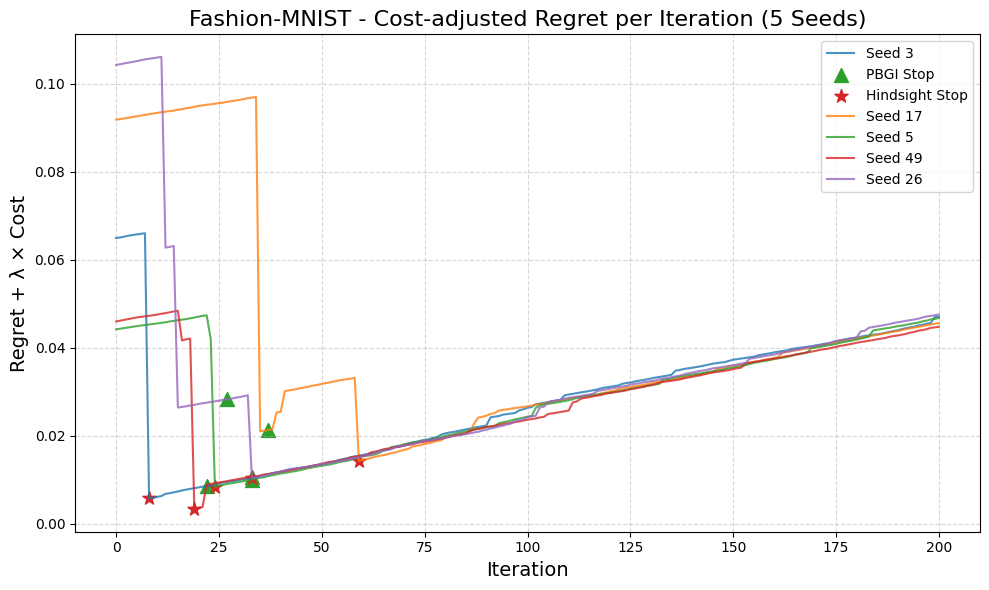

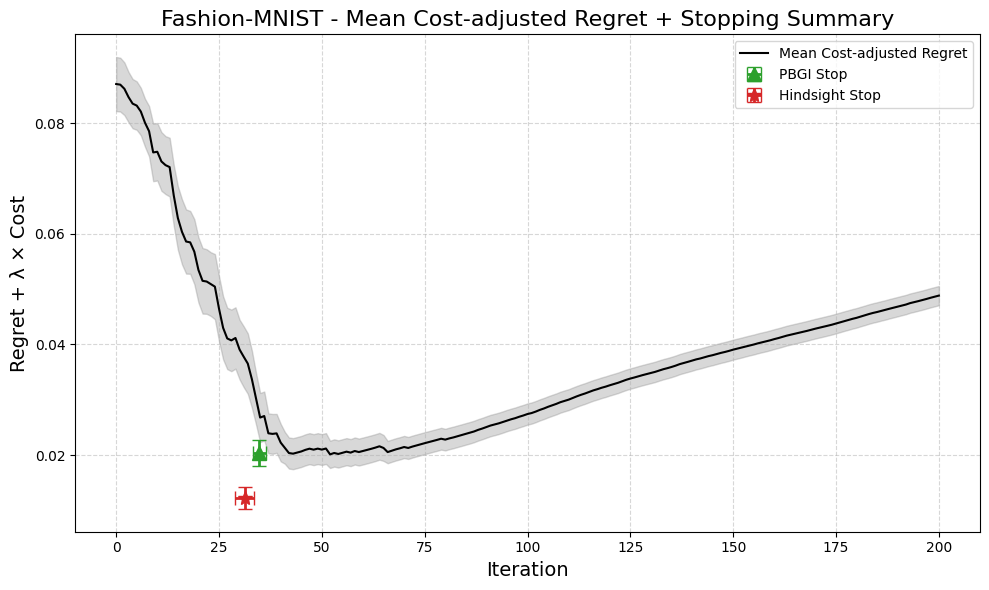

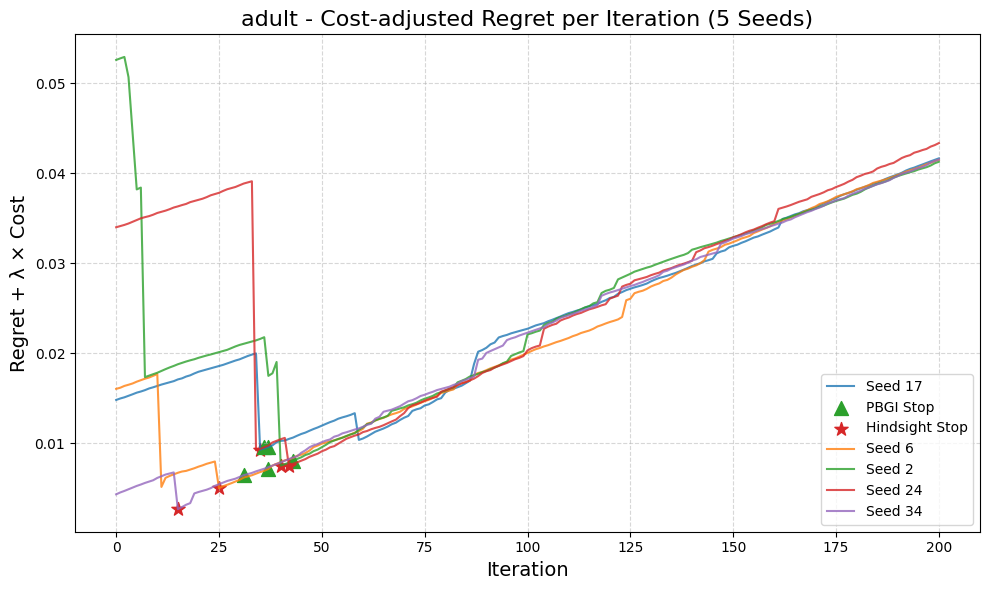

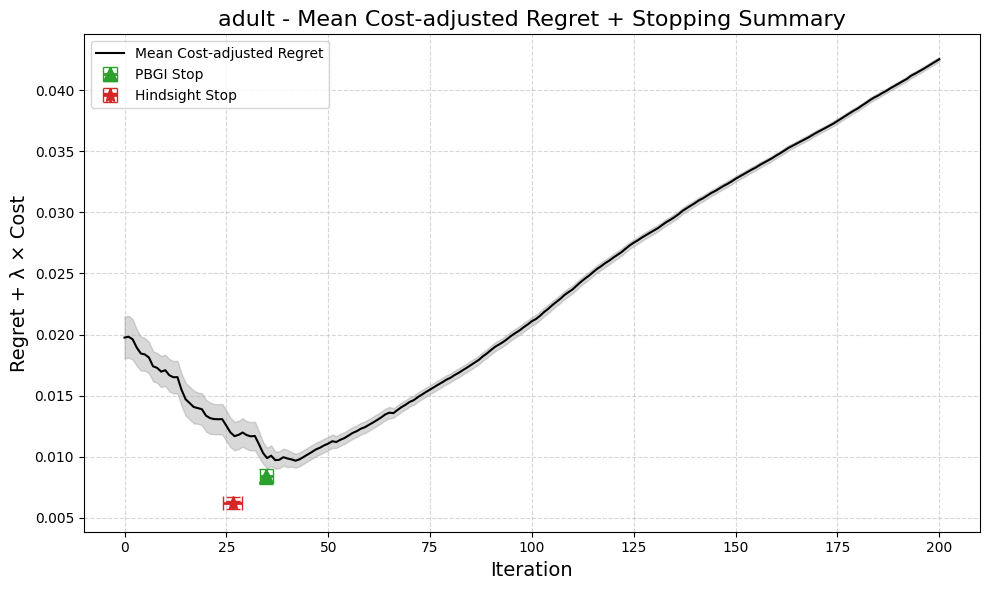

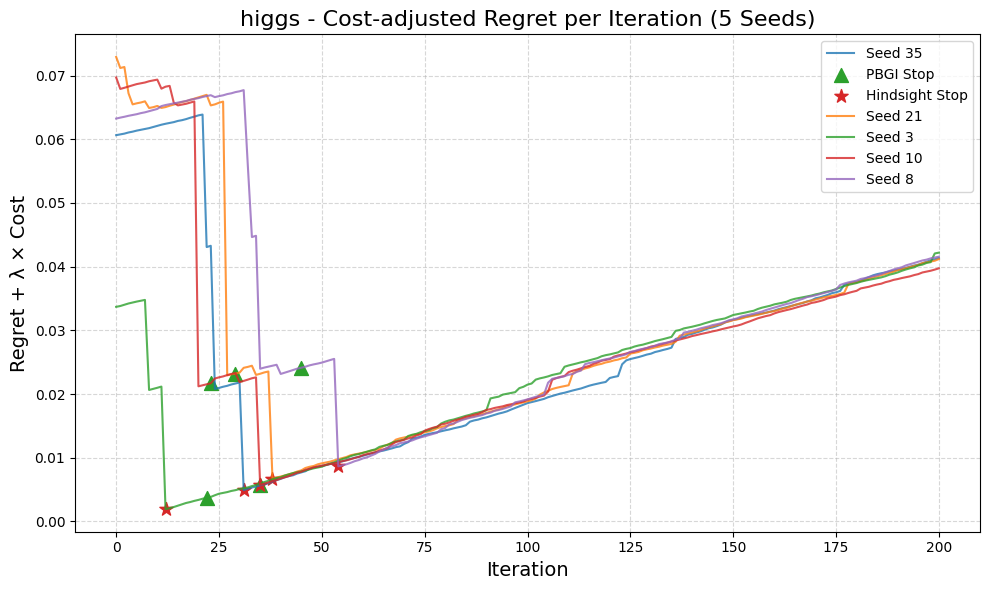

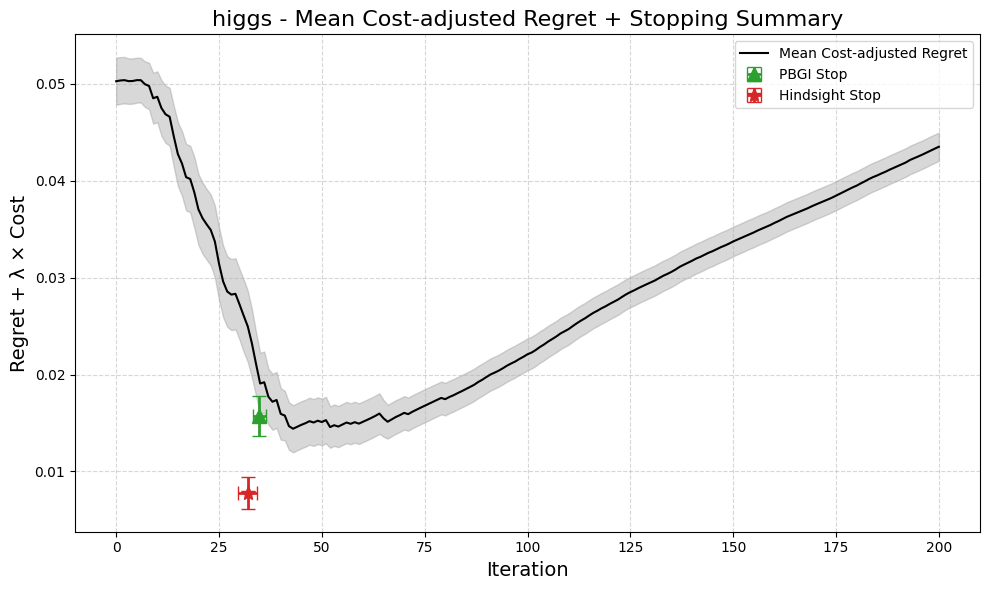

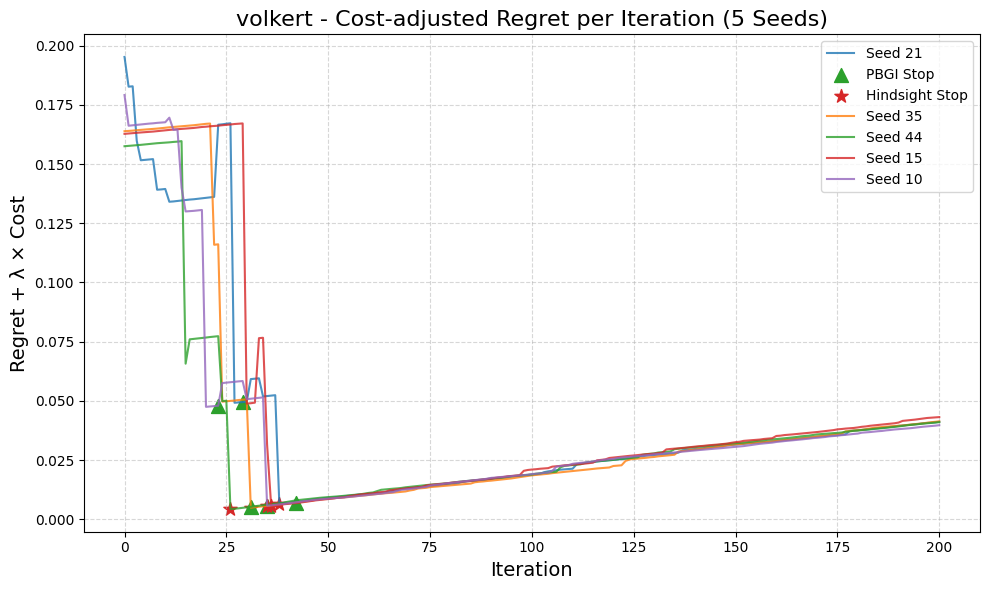

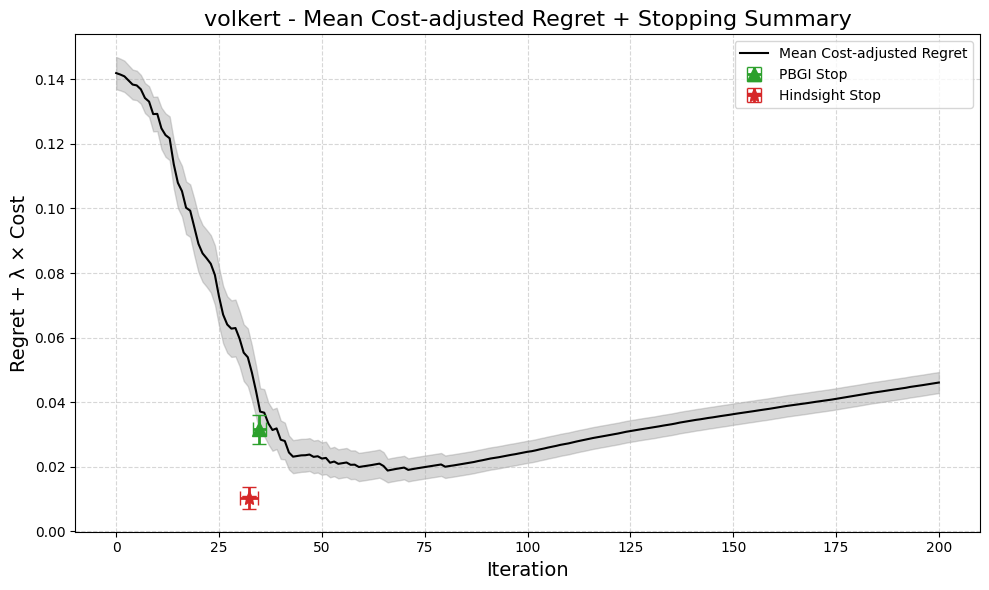

In [59]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(123)

for d in dataset_names:
    best_test_ce = bench.query_best_final(d, "final_test_cross_entropy", "final_test_cross_entropy", 1999)
    all_seed_ids = list(range(len(cumulative_cost_per_acq[d][fixed_acq])))
    sampled_seed_ids = random.sample(all_seed_ids, 5)

    # === 1. Plot 5 individual seeds with stopping points ===
    plt.figure(figsize=(10, 6))

    for seed_id in sampled_seed_ids:
        test_ce_arr = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        cost_arr = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])

        regret_arr = test_ce_arr - best_test_ce
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        plt.plot(range(len(adjusted_regret_arr)), adjusted_regret_arr, label=f"Seed {seed_id}", alpha=0.8)

        # Stopping points
        try:
            stop_id_pbgi = next(i for i in range(1, len(test_ce_arr))
                                if PBGI_1e_6_acq_per_acq[d][fixed_acq][seed_id][i] >=
                                current_best_observed_per_acq[d][fixed_acq][seed_id][i-1])
        except StopIteration:
            stop_id_pbgi = None

        if stop_id_pbgi is not None:
            stop_val_pbgi = adjusted_regret_arr[stop_id_pbgi]
            plt.scatter(stop_id_pbgi, stop_val_pbgi, color='tab:green', marker='^', s=100, label=f"PBGI Stop" if seed_id == sampled_seed_ids[0] else None)

        # Hindsight stopping
        regret_arr_full = regret_arr + lmbda * cost_arr
        stop_id_hindsight = np.argmin(regret_arr_full)
        stop_val_hindsight = regret_arr_full[stop_id_hindsight]
        plt.scatter(stop_id_hindsight, stop_val_hindsight, color='tab:red', marker='*', s=100, label=f"Hindsight Stop" if seed_id == sampled_seed_ids[0] else None)

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Regret + λ × Cost", fontsize=14)
    plt.title(f"{d} - Cost-adjusted Regret per Iteration (5 Seeds)", fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === 2. Plot mean curve and (mean iteration, mean regret) with error bars ===
    plt.figure(figsize=(10, 6))

    # Interpolated mean curve
    max_len = max(len(test_cross_entropy_per_acq[d][fixed_acq][seed_id]) for seed_id in all_seed_ids)
    interpolated_adjusted_regrets = []

    for seed_id in all_seed_ids:
        test_ce_arr = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        cost_arr = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])
        regret_arr = test_ce_arr - best_test_ce
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        padded = np.full(max_len, np.nan)
        padded[:len(adjusted_regret_arr)] = adjusted_regret_arr
        interpolated_adjusted_regrets.append(padded)

    interpolated_adjusted_regrets = np.array(interpolated_adjusted_regrets)
    mean_adjusted_regret = np.nanmean(interpolated_adjusted_regrets, axis=0)
    sem_adjusted_regret = np.nanstd(interpolated_adjusted_regrets, axis=0) / np.sqrt(np.sum(~np.isnan(interpolated_adjusted_regrets), axis=0))

    plt.plot(range(max_len), mean_adjusted_regret, color="black", label="Mean Cost-adjusted Regret")
    plt.fill_between(range(max_len),
                     mean_adjusted_regret - sem_adjusted_regret,
                     mean_adjusted_regret + sem_adjusted_regret,
                     color="gray", alpha=0.3)

    # --- Mean (iteration, regret) for PBGI and Hindsight ---
    stopping_info = {'PBGI': {'stop_iters': [], 'stop_vals': []},
                     'Hindsight': {'stop_iters': [], 'stop_vals': []}}

    for seed_id in all_seed_ids:
        test_ce_arr = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        cost_arr = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])
        regret_arr = test_ce_arr - best_test_ce
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        # PBGI stopping
        try:
            stop_id_pbgi = next(i for i in range(1, len(test_ce_arr))
                                if PBGI_1e_6_acq_per_acq[d][fixed_acq][seed_id][i] >=
                                current_best_observed_per_acq[d][fixed_acq][seed_id][i-1])
            stopping_info['PBGI']['stop_iters'].append(stop_id_pbgi)
            stopping_info['PBGI']['stop_vals'].append(adjusted_regret_arr[stop_id_pbgi])
        except StopIteration:
            pass

        # Hindsight stopping
        stop_id_hindsight = np.argmin(adjusted_regret_arr)
        stopping_info['Hindsight']['stop_iters'].append(stop_id_hindsight)
        stopping_info['Hindsight']['stop_vals'].append(adjusted_regret_arr[stop_id_hindsight])

    # --- Plot mean ± sem points for each rule ---
    for rule_name, info in stopping_info.items():
        if info['stop_iters']:
            iters = np.array(info['stop_iters'])
            vals = np.array(info['stop_vals'])

            mean_iter = np.mean(iters)
            sem_iter = np.std(iters) / np.sqrt(len(iters))

            mean_val = np.mean(vals)
            sem_val = np.std(vals) / np.sqrt(len(vals))

            marker = '^' if rule_name == 'PBGI' else '*'
            color = 'tab:green' if rule_name == 'PBGI' else 'tab:red'

            plt.errorbar(mean_iter, mean_val,
                         xerr=sem_iter, yerr=sem_val,
                         fmt=marker, color=color,
                         markersize=10, capsize=5, linewidth=2,
                         label=f"{rule_name} Stop")

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Regret + λ × Cost", fontsize=14)
    plt.title(f"{d} - Mean Cost-adjusted Regret + Stopping Summary", fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

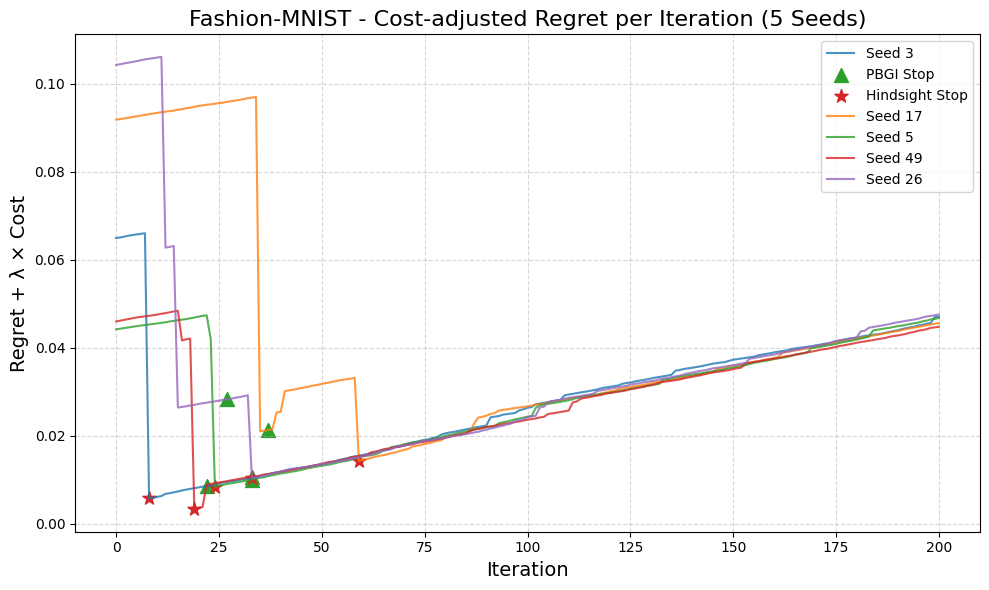

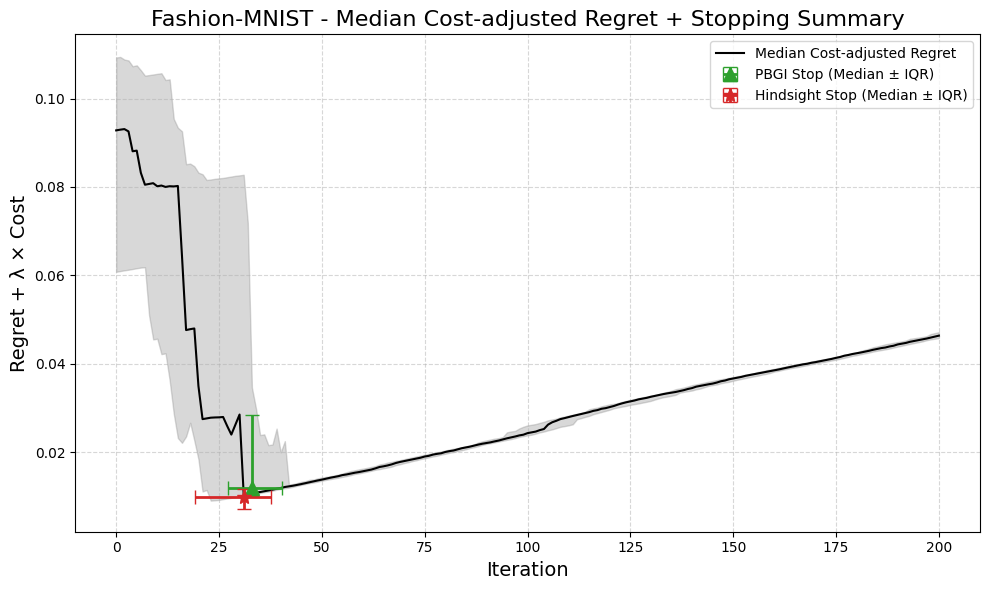

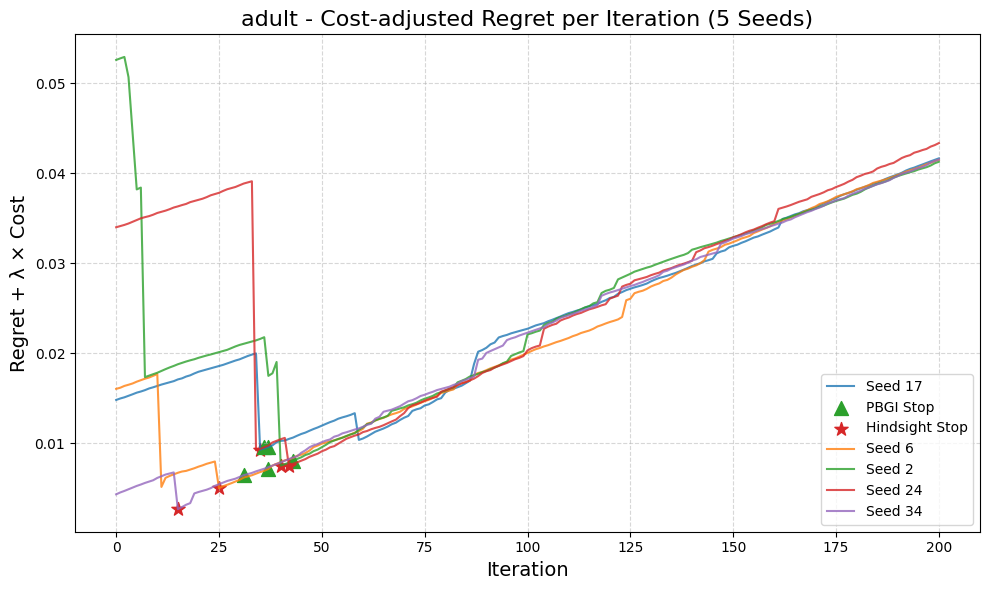

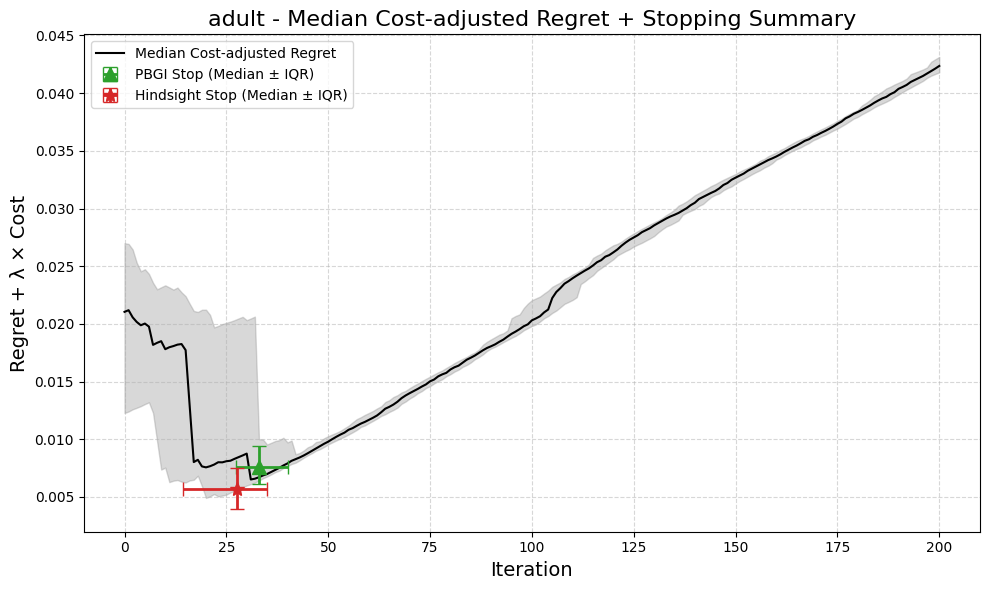

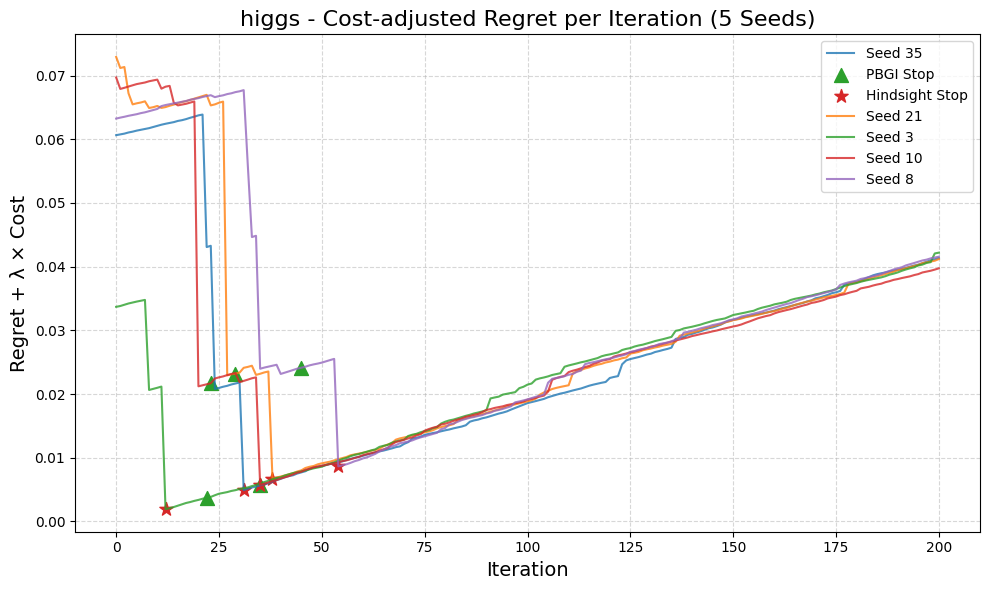

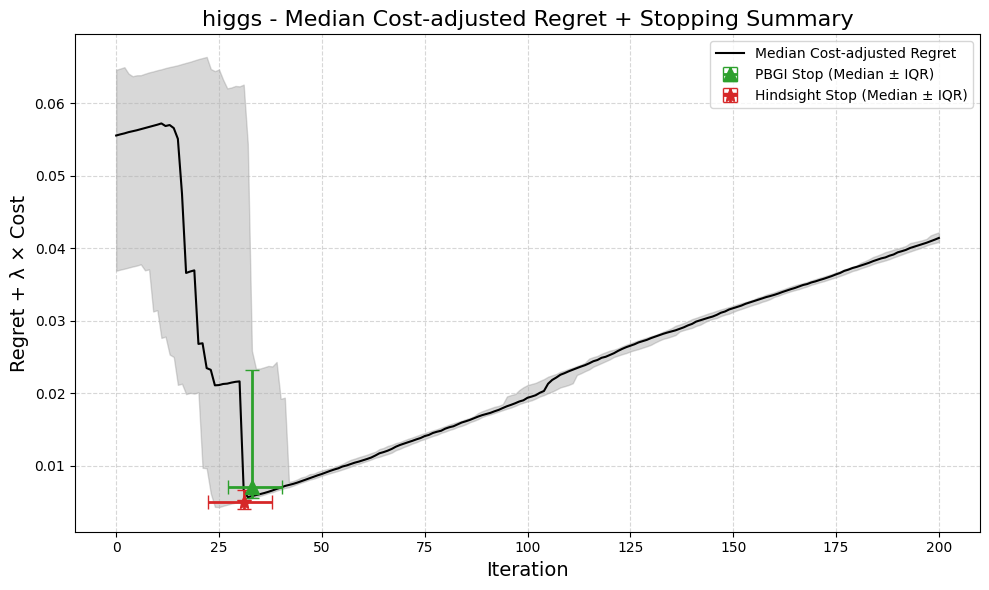

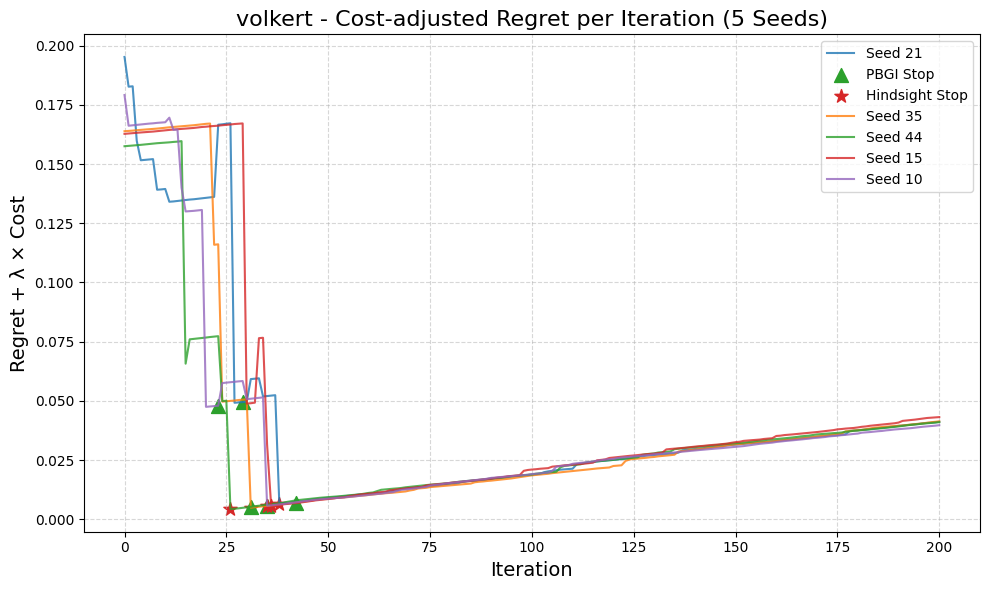

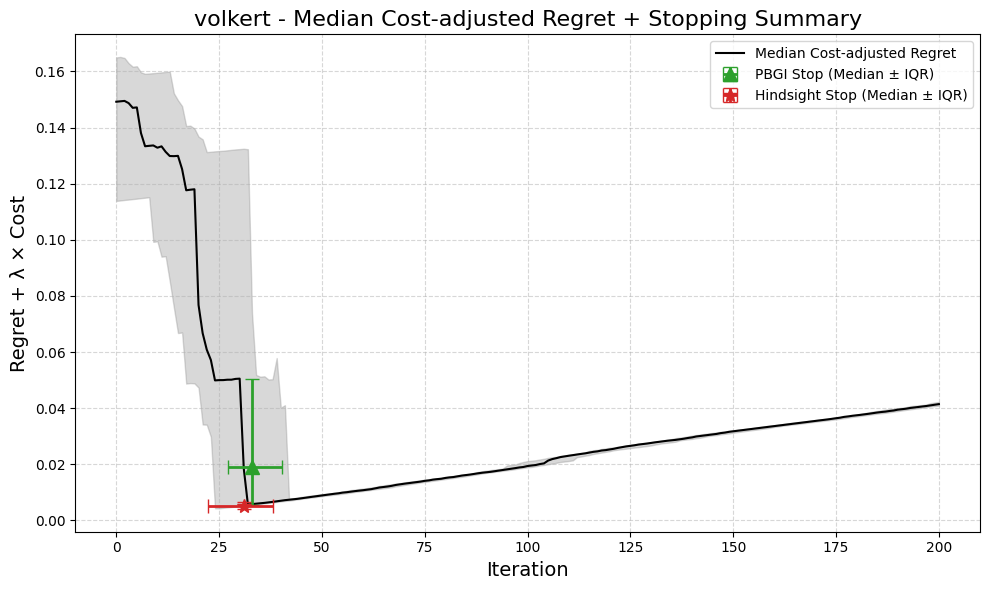

In [60]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(123)

for d in dataset_names:
    best_test_ce = bench.query_best_final(d, "final_test_cross_entropy", "final_test_cross_entropy", 1999)
    all_seed_ids = list(range(len(cumulative_cost_per_acq[d][fixed_acq])))
    sampled_seed_ids = random.sample(all_seed_ids, 5)

    # === 1. Plot 5 individual seeds with stopping points ===
    plt.figure(figsize=(10, 6))

    for seed_id in sampled_seed_ids:
        test_ce_arr = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        cost_arr = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])

        regret_arr = test_ce_arr - best_test_ce
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        plt.plot(range(len(adjusted_regret_arr)), adjusted_regret_arr, label=f"Seed {seed_id}", alpha=0.8)

        # Stopping points
        try:
            stop_id_pbgi = next(i for i in range(1, len(test_ce_arr))
                                if PBGI_1e_6_acq_per_acq[d][fixed_acq][seed_id][i] >=
                                current_best_observed_per_acq[d][fixed_acq][seed_id][i-1])
        except StopIteration:
            stop_id_pbgi = None

        if stop_id_pbgi is not None:
            stop_val_pbgi = adjusted_regret_arr[stop_id_pbgi]
            plt.scatter(stop_id_pbgi, stop_val_pbgi, color='tab:green', marker='^', s=100, label=f"PBGI Stop" if seed_id == sampled_seed_ids[0] else None)

        # Hindsight stopping
        regret_arr_full = regret_arr + lmbda * cost_arr
        stop_id_hindsight = np.argmin(regret_arr_full)
        stop_val_hindsight = regret_arr_full[stop_id_hindsight]
        plt.scatter(stop_id_hindsight, stop_val_hindsight, color='tab:red', marker='*', s=100, label=f"Hindsight Stop" if seed_id == sampled_seed_ids[0] else None)

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Regret + λ × Cost", fontsize=14)
    plt.title(f"{d} - Cost-adjusted Regret per Iteration (5 Seeds)", fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === 2. Plot median ± quartiles across all seeds ===
    plt.figure(figsize=(10, 6))

    # Interpolated adjusted regrets
    max_len = max(len(test_cross_entropy_per_acq[d][fixed_acq][seed_id]) for seed_id in all_seed_ids)
    interpolated_adjusted_regrets = []

    for seed_id in all_seed_ids:
        test_ce_arr = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        cost_arr = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])
        regret_arr = test_ce_arr - best_test_ce
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        padded = np.full(max_len, np.nan)
        padded[:len(adjusted_regret_arr)] = adjusted_regret_arr
        interpolated_adjusted_regrets.append(padded)

    interpolated_adjusted_regrets = np.array(interpolated_adjusted_regrets)

    median_adjusted_regret = np.nanmedian(interpolated_adjusted_regrets, axis=0)
    lower_quartile = np.nanpercentile(interpolated_adjusted_regrets, 25, axis=0)
    upper_quartile = np.nanpercentile(interpolated_adjusted_regrets, 75, axis=0)

    plt.plot(range(max_len), median_adjusted_regret, color="black", label="Median Cost-adjusted Regret")
    plt.fill_between(range(max_len), lower_quartile, upper_quartile, color="gray", alpha=0.3)

    # --- Stopping info for PBGI and Hindsight ---
    stopping_info = {'PBGI': {'stop_iters': [], 'stop_vals': []},
                     'Hindsight': {'stop_iters': [], 'stop_vals': []}}

    for seed_id in all_seed_ids:
        test_ce_arr = np.array(test_cross_entropy_per_acq[d][fixed_acq][seed_id])
        cost_arr = np.array(cumulative_cost_per_acq[d][fixed_acq][seed_id])
        regret_arr = test_ce_arr - best_test_ce
        adjusted_regret_arr = regret_arr + lmbda * cost_arr

        # PBGI stopping
        try:
            stop_id_pbgi = next(i for i in range(1, len(test_ce_arr))
                                if PBGI_1e_6_acq_per_acq[d][fixed_acq][seed_id][i] >=
                                current_best_observed_per_acq[d][fixed_acq][seed_id][i-1])
            stopping_info['PBGI']['stop_iters'].append(stop_id_pbgi)
            stopping_info['PBGI']['stop_vals'].append(adjusted_regret_arr[stop_id_pbgi])
        except StopIteration:
            pass

        # Hindsight stopping
        stop_id_hindsight = np.argmin(adjusted_regret_arr)
        stopping_info['Hindsight']['stop_iters'].append(stop_id_hindsight)
        stopping_info['Hindsight']['stop_vals'].append(adjusted_regret_arr[stop_id_hindsight])

    # --- Plot median stop (iteration, regret) + quartiles ---
    for rule_name, info in stopping_info.items():
        if info['stop_iters']:
            iters = np.array(info['stop_iters'])
            vals = np.array(info['stop_vals'])

            median_iter = np.median(iters)
            q1_iter = np.percentile(iters, 25)
            q3_iter = np.percentile(iters, 75)

            median_val = np.median(vals)
            q1_val = np.percentile(vals, 25)
            q3_val = np.percentile(vals, 75)

            marker = '^' if rule_name == 'PBGI' else '*'
            color = 'tab:green' if rule_name == 'PBGI' else 'tab:red'

            plt.errorbar(median_iter, median_val,
                         xerr=[[median_iter - q1_iter], [q3_iter - median_iter]],
                         yerr=[[median_val - q1_val], [q3_val - median_val]],
                         fmt=marker, color=color,
                         markersize=10, capsize=5, linewidth=2,
                         label=f"{rule_name} Stop (Median ± IQR)")

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Regret + λ × Cost", fontsize=14)
    plt.title(f"{d} - Median Cost-adjusted Regret + Stopping Summary", fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()